In [28]:
import open3d as o3d
import numpy as np
import os
import cv2
import copy
import matplotlib.pyplot as plt
from scipy.io import wavfile

storage_path = "data/"
isRunning = True
lis_coords = [[0, 0, 0.5], [0, 0, 0.6], [0, 0, 0.54], [0, 0, 0.4]]
filename_strs = [
    "box_paper",
    "box_paper_withangle",
    "iron_rect_black_withangle",
    "iron_rect1_black",
]


def key_callback(vis, action, mods):
    global isRunning
    if action == 0:
        isRunning = False

In [29]:
idx = 3

H:  360  W:  640


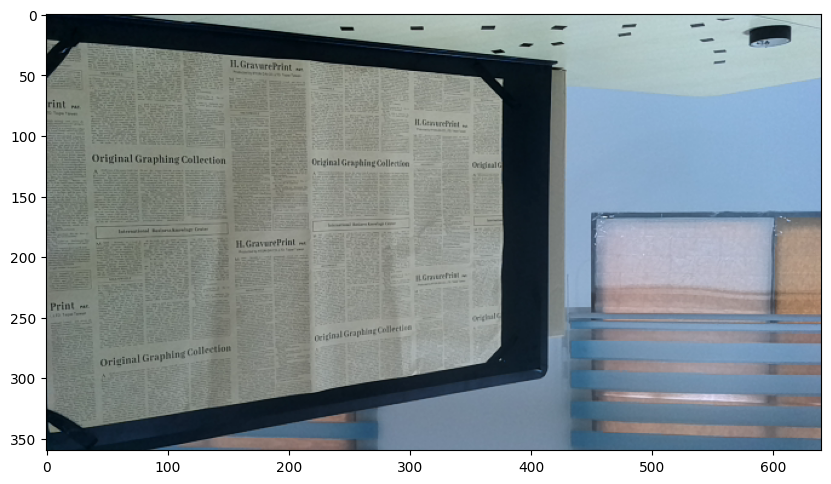

In [30]:
# 复现点云
idx -= 1
isRunning = True
pt_data = np.load(f"../data/{filename_strs[idx]}.npz")
points = pt_data["points"] / 1000  # 转换格式
colors = pt_data["colors"]
points[:, -1] += 0.02  # 误差修正
vis = o3d.visualization.VisualizerWithKeyCallback()
vis.create_window()
vis.register_key_action_callback(81, key_callback)
pcd = o3d.geometry.PointCloud()
coordinateFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=1, origin=[0, 0, 0]
)
vis.add_geometry(coordinateFrame)

pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)
vis.add_geometry(pcd)
vis.poll_events()
vis.update_renderer()
while isRunning:
    key = cv2.waitKey(1)
    vis.update_geometry(pcd)
    if key == ord("q"):
        break

    vis.poll_events()
    vis.update_renderer()


vis.destroy_window()

Height = 40 * 9
Width = 40 * 16
channels = 3
assert Height * Width == points.shape[0]

# 查看图片
rescale_colors = 255 * colors
rescale_colors = rescale_colors.astype(np.uint8).reshape((Height, Width, channels))

print("H: ", rescale_colors.shape[0], " W: ", rescale_colors.shape[1])
plt.figure(figsize=(10, 10))
plt.imshow(rescale_colors)

In [31]:
pcd_masked = o3d.geometry.PointCloud()
np_points = np.array(pcd.points)
np_colors = np.array(pcd.colors)
mask1 = np_points[:, 2] <= 1.5
mask2 = np_points[:, 2] > 0.5
mask = np.logical_and(mask1, mask2)

pcd_masked.points = o3d.utility.Vector3dVector(np_points[mask])
pcd_masked.colors = o3d.utility.Vector3dVector(np_colors[mask])

In [32]:
output_obj_file = f"../obj1/reconstructed_mesh_{idx+1}.obj"
# view obj
mesh = o3d.io.read_triangle_mesh(output_obj_file)
assert mesh.has_vertices(), "OBJ file has no vertices"

if not mesh.has_vertex_normals():
    print(f"mesh vertex not computed, will be calculated")
    mesh.compute_vertex_normals()

o3d.visualization.draw_geometries(
    [mesh],
    window_name=f"Open3D - {output_obj_file}",
    mesh_show_wireframe=True,  # 可以设置为 True 以显示线框
    mesh_show_back_face=True,
)

In [ ]:
# 使用pygsound
import pygsound as ps
from wavefile import WaveWriter, Format

ctx = ps.Context()
ctx.diffuse_count = 2000000
ctx.specular_count = 20000
ctx.channel_type = ps.ChannelLayoutType.stereo

absorption_coefficients = 0.5
scattering_coefficients = 0.0

meshA = ps.loadobj(output_obj_file, absorption_coefficients, scattering_coefficients)
scene = ps.Scene()
scene.setMesh(meshA)
src_coord = [0, 0, 0]
src = ps.Source(src_coord)
src.power = 1.0
src.radius = 0.025
lis = ps.Listener(lis_coords[idx])
lis.radius = 0.025


res = scene.computeIR(
    [src], [lis], ctx
)  # you may pass lists of sources and listeners to get N_src x N_lis IRs
audio_data = np.array(
    res["samples"][0][0]
)  # the IRs are indexed by [i_src, i_lis, i_channel]
with WaveWriter(
    "test1.wav", channels=audio_data.shape[0], samplerate=int(res["rate"])
) as w1:
    w1.write(audio_data)
    print("IR using .obj input written to test1.wav.")

rir_gs = res["samples"][0][0][0]
sample_rate = int(res["rate"])
time_tick = np.arange(len(rir_gs)) / sample_rate

fig, axs = plt.subplots(1, 1, figsize=(16, 10))
axs.plot(time_tick, rir_gs)
axs.set_xlim(0, 0.02)
axs.set_xlabel("time (s)")
axs.set_ylim(0, 1)
axs.set_ylabel("Amplitude")

fig.tight_layout()
plt.savefig(f"../img/IR_{idx+1}_early.png")
plt.grid(True)
plt.show()

print(f"sample rate : ", int(res["rate"]))
sorted_arg = np.argsort(np.abs(rir_gs))[::-1]
print(f"Amplitutde pulse: {sorted_arg[:15]}")

SyntaxError: invalid syntax (3338436278.py, line 14)

Successfully write possion obj file



numDirectRays: Amplitutde pulse 15 strongest idx: [ 75 218 187 196 202 190 207  78 189 193 203 205  77 200 191]
Execute time in function mesh and trace: 22650 ms. Trace using 2660 ms.
sample rate:  48000
200
maxSpecularDepth: 200
numSpecularRays: 20000
numSpecularSamples: 100
maxDiffuseDepth: 200
numDiffuseRays: 2000000
numDiffuseSamples: 3
maxDiffractionDepth: 0
maxDiffractionOrder: 3
responseTime: 5
visibilityCacheTime: 5
rayOffset: 0.0001
numThreads: 8
minQuality: 0.25
maxQuality: 1.5
quality: 1


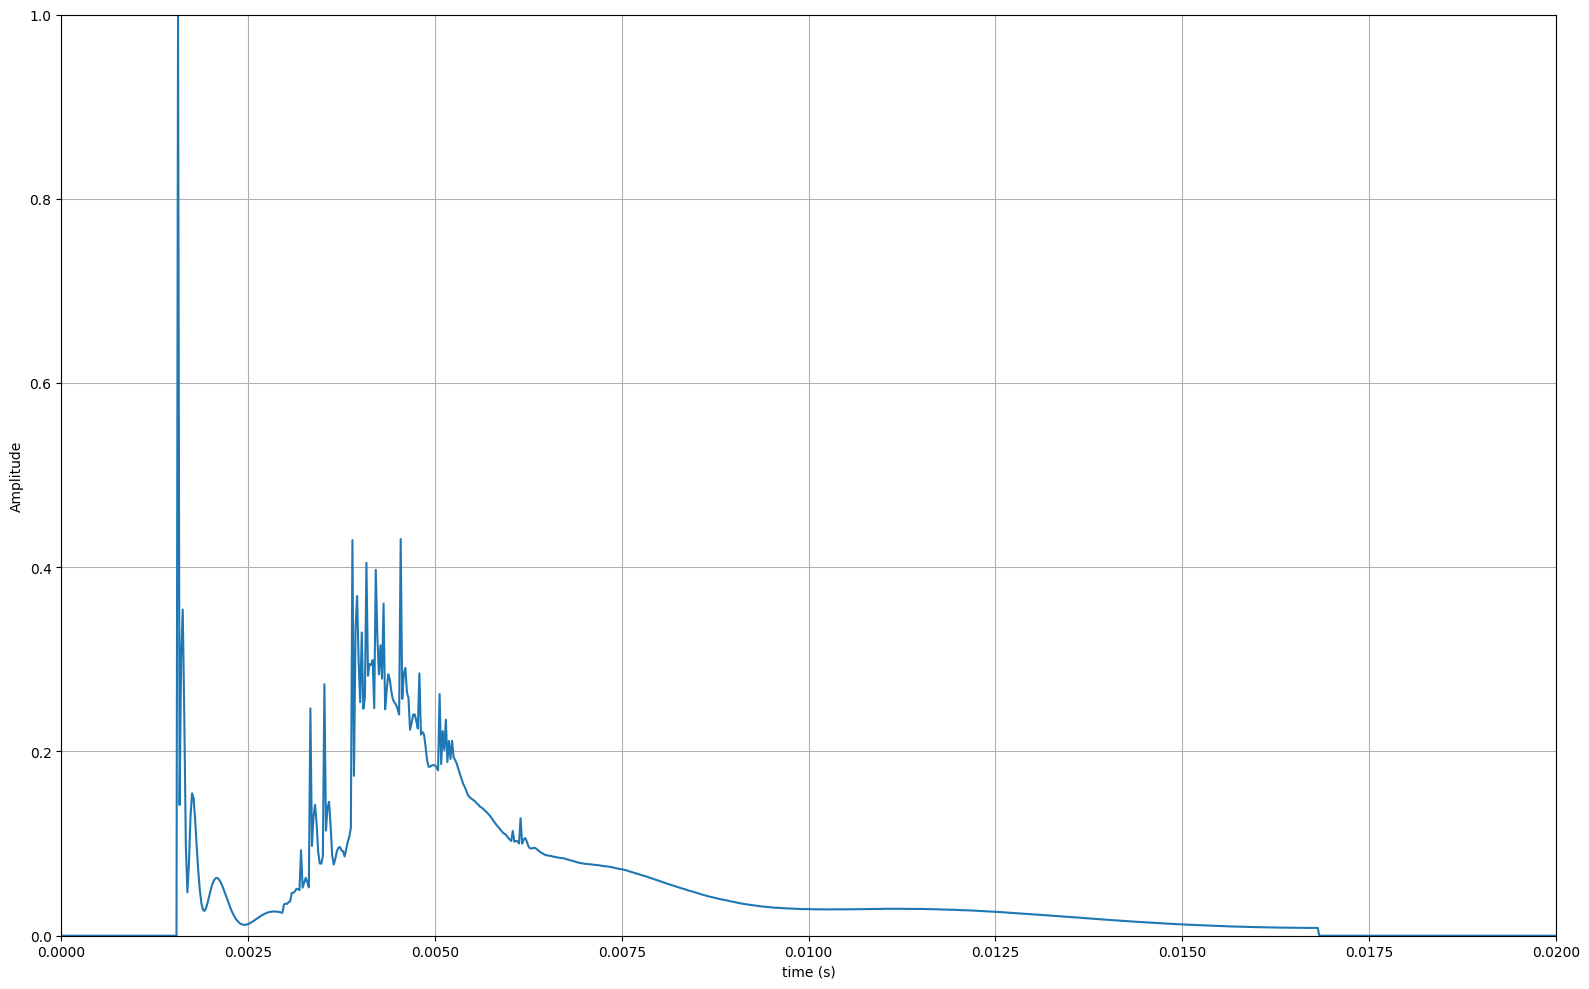

In [ ]:
import gsound

result = gsound.mesh_and_trace(
    pcd_masked,
    lis_coord=lis_coords[idx],
    output_path="../obj1/",
    file_name=f"reconstructed_mesh_{idx+1}",
)
print("sample rate: ", result[1])
gsound.pygsound_plot(
    result[0], result[1], save_plot=True, file_name=f"IR_{idx+1}_early"
)